In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing the results

In [2]:
currdir = os.getcwd()
regex_name = r'(([A-Z])\w+)'
batchrun = '600s-run1'

In [7]:
entrances = [
    '0x16 - Northern_Southbound_Lane1',
    '0x3 - Northern_Southbound_Lane2_Lane3',
    '0x17 - Northern_Southbound_Lane4',
    '0x15 - Eastern_Westbound_Lane1',
    '0x0 - Eastern_Westbound_Lane2_Lane3',
    '0x14 - Eastern_Westbound_Lane4',
    '0x12 - Southern_Northbound_Lane1',
    '0x1 - Southern_Northbound_Lane2_Lane3',
    '0x13 - Southern_Northbound_Lane4',
    '0x10 - Western_EastBound_Lane1',
    '0x2 - Western_EastBound_Lane2_Lane3',
    '0x11 - Western_EastBound_Lane4',
]

exits = [
    '0xe - Northern_Northbound_Lane1',
    '0x7 - Northern_Northbound_Lane2_Lane3',
    '0xf - Northern_Northbound_Lane4',
    '0xc - Eastern_Eastbound_Lane1',
    '0x5 - Eastern_Eastbound_Lane2_Lane3',
    '0xd - Eastern_Eastbound_Lane4',
    '0xb - Southern_Southbound_Lane1',
    '0x4 - Southern_Southbound_Lane2_Lane3',
    '0xa - Southern_Southbound_Lane4',
    '0x9 - Western_WestBound_Lane1',
    '0x6 - Western_WestBound_Lane2_Lane3',
    '0x8 - Western_WestBound_Lane4',
]

roads = entrances + exits

entrances_rename = {
    '0x16 - Northern_Southbound_Lane1': ('north', 'left'),
    '0x3 - Northern_Southbound_Lane2_Lane3': ('north', 'through'),
    '0x17 - Northern_Southbound_Lane4': ('north', 'right'),
    
    '0x15 - Eastern_Westbound_Lane1': ('east', 'right'),
    '0x0 - Eastern_Westbound_Lane2_Lane3': ('east', 'through'),
    '0x14 - Eastern_Westbound_Lane4': ('east', 'left'),
    
    '0x12 - Southern_Northbound_Lane1': ('south', 'left'),
    '0x1 - Southern_Northbound_Lane2_Lane3': ('south', 'through'),
    '0x13 - Southern_Northbound_Lane4': ('south', 'right'),
    
    '0x10 - Western_EastBound_Lane1': ('west', 'left'),
    '0x2 - Western_EastBound_Lane2_Lane3': ('west', 'through'),
    '0x11 - Western_EastBound_Lane4': ('west', 'right'),
}

exits_rename = {
    '0xe - Northern_Northbound_Lane1': ('west', 'left'),
    '0x7 - Northern_Northbound_Lane2_Lane3': ('south', 'through'),
    '0xf - Northern_Northbound_Lane4': ('east', 'right'),
    
    '0xc - Eastern_Eastbound_Lane1': ('north', 'left'),
    '0x5 - Eastern_Eastbound_Lane2_Lane3': ('west', 'through'),
    '0xd - Eastern_Eastbound_Lane4': ('south', 'right'),
    
    '0xb - Southern_Southbound_Lane1': ('east', 'left'),
    '0x4 - Southern_Southbound_Lane2_Lane3': ('north', 'through'),
    '0xa - Southern_Southbound_Lane4': ('west', 'right'),
    
    '0x9 - Western_WestBound_Lane1': ('south', 'left'),
    '0x6 - Western_WestBound_Lane2_Lane3': ('east', 'through'),
    '0x8 - Western_WestBound_Lane4': ('north', 'right'),
}

In [18]:
df_delay = pd.DataFrame(data=[], index=[], columns=entrances+['demand', 'cycle'])
df_throughput = pd.DataFrame(data=[], index=[], columns=exits+['demand', 'cycle'])

for demand in range(450,901,50):
    for cycle in range(50,301,50):
        filename = currdir + '/prelims/result-4leg-{}-{}.xls'.format(demand, cycle)
        df_tmp = pd.read_excel(filename, sheet_name='Speed')
        
        df_tmp_delay = df_tmp[entrances][df_tmp.t == 'Average Delay']
        df_tmp_delay['demand'] = [demand]
        df_tmp_delay['cycle'] = [cycle]
        df_delay = pd.concat([df_delay, df_tmp_delay])
        
        df_tmp_through = df_tmp[exits][df_tmp.t == 'Throughput']
        df_tmp_through['demand'] = [demand]
        df_tmp_through['cycle'] = [cycle]
        df_throughput = pd.concat([df_throughput, df_tmp_through])

In [19]:
df_delay.rename(columns=entrances_rename, inplace=True)
df_throughput.rename(columns=exits_rename, inplace=True)

In [33]:
_df_tmp1 = df_delay.set_index(['demand', 'cycle']).stack().reset_index(name="delay")
_df_tmp1['approach'] = _df_tmp1['level_2'].apply(lambda x: x[0])
_df_tmp1['turn'] = _df_tmp1['level_2'].apply(lambda x: x[1])
_df_tmp1.drop(['level_2'], axis=1, inplace=True)

_df_tmp2 = df_throughput.set_index(['demand', 'cycle']).stack().reset_index(name="throughput")
_df_tmp2['approach'] = _df_tmp2['level_2'].apply(lambda x: x[0])
_df_tmp2['turn'] = _df_tmp2['level_2'].apply(lambda x: x[1])
_df_tmp2.drop(['level_2'], axis=1, inplace=True)

In [34]:
_df_tmp1.to_pickle('{}-delay-new.pkl'.format(batchrun))
_df_tmp2.to_pickle('{}-throughput-new.pkl'.format(batchrun))

## Combine and average the runs

In [2]:
df_delay = pd.read_pickle('600s-run1-delay-new.pkl')

In [3]:
df_throughput = pd.read_pickle('600s-run1-throughput-new.pkl')

## Visualizing how delay changes

In [4]:
df_delay_map = df_delay.groupby(['demand', 'cycle']).agg({'delay': 'mean'}).reset_index().pivot(index='demand', columns='cycle', values='delay')
df_delay_map

cycle,50,100,150,200,250,300
demand,,,,,,
450,80.722115,51.940149,60.935191,64.639030,74.854355,71.656019
500,74.960457,66.151111,63.804385,60.958475,75.682265,68.209580
550,90.210286,70.029546,70.271717,74.159141,72.426097,70.071104
600,92.393984,75.224122,69.698769,78.659668,77.720944,69.987534
650,104.248538,83.533207,76.376092,78.379214,78.041808,75.779211
700,101.143304,82.283317,78.216704,75.595946,81.825447,77.622924
750,101.685031,87.084287,79.302957,78.148869,83.949707,78.246771
800,107.036854,86.986840,83.826541,79.476547,81.383720,76.735873
850,105.830946,89.027351,83.049511,81.173698,81.995241,80.570705


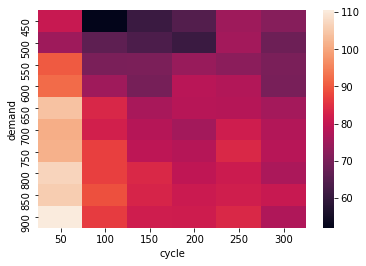

In [5]:
sns.heatmap(data=df_delay_map)

Maybe the first cycle value is too high that it overshadows the others?

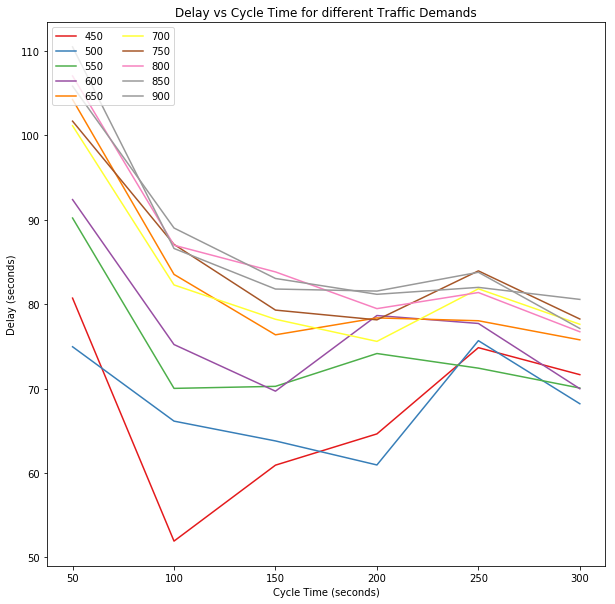

In [23]:
palette = plt.get_cmap('Set1')
df_delay_transpose = df_delay_map.transpose()

fig, ax = plt.subplots(1,1,figsize=(10,10))

num=0
for column in df_delay_transpose:
    plt.plot(df_delay_transpose.index, df_delay_transpose[column], marker='', color=palette(num), linewidth=1.5, label=column)
    num+=1
    
    # Add legend
    plt.legend(loc=2, ncol=2)

    # Add titles
    plt.title("Delay vs Cycle Time for different Traffic Demands")
    plt.xlabel("Cycle Time (seconds)")
    plt.ylabel("Delay (seconds)")

## Visualizing how throughput changes

In [26]:
df_throughput_map = df_throughput.groupby(['demand', 'cycle']).agg({'throughput': 'sum'}).reset_index().pivot(index='demand', columns='cycle', values='throughput')
df_throughput_map

cycle,50,100,150,200,250,300
demand,,,,,,
450,954.0,968.0,1019.0,983.0,973.0,976.0
500,1019.0,1126.0,1096.0,1125.0,1075.0,1083.0
550,1021.0,1129.0,1131.0,1130.0,1111.0,1104.0
600,1076.0,1187.0,1200.0,1207.0,1193.0,1144.0
650,1077.0,1208.0,1233.0,1219.0,1248.0,1210.0
700,1096.0,1267.0,1283.0,1292.0,1279.0,1266.0
750,1142.0,1306.0,1320.0,1351.0,1383.0,1333.0
800,1142.0,1328.0,1381.0,1377.0,1416.0,1341.0
850,1220.0,1352.0,1401.0,1409.0,1403.0,1399.0


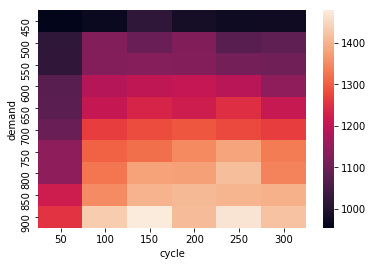

In [27]:
sns.heatmap(data=df_throughput_map)

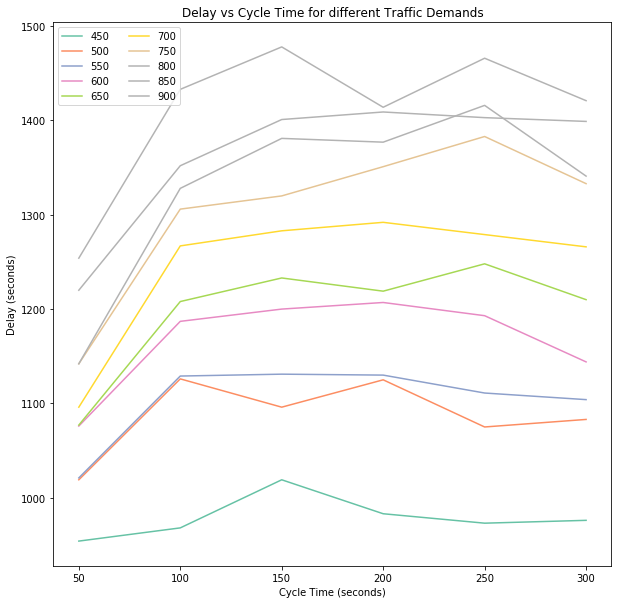

In [28]:
palette = plt.get_cmap('Set2')
df_throughput_transpose = df_throughput_map.transpose()

fig, ax = plt.subplots(1,1,figsize=(10,10))

num=0
for column in df_throughput_transpose:
    plt.plot(df_throughput_transpose.index, df_throughput_transpose[column], marker='', color=palette(num), linewidth=1.5, label=column)
    num+=1
    
    # Add legend
    plt.legend(loc=2, ncol=2)

    # Add titles
    plt.title("Delay vs Cycle Time for different Traffic Demands")
    plt.xlabel("Cycle Time (seconds)")
    plt.ylabel("Delay (seconds)")